# MINI-PROJECT 2    
## Regression Analysis and Forecasting Using time-ordered COVID-19 related Data sets
### QINTONG LI
### Date: 13/11/2021

---

# <a id="content"></a> CONTENT

# [Introduction](#intro)
* ### Background information
* ### Background setup



# Import Data

## 1. [Import COVID metrics](#covid)
* ### API packages from UK government website

## 2. [Import mobility metrics (Predictors)](#mobility)
* ### Predictors from Google mobility metrics


# Analysis

## 3. [Data cleaning](#data)
* ### [Shifting](#shift)
* ### [Using rolling means to eliminate periodic fluactions](#rolling)
* ### [Selecting](#s)

## 4. [Linear Regression](#lr)
* ### [Initial Linear Regression model](#initial)
     * #### [Plotting](#pi)
     * #### [Back test](#backi)
* ### [Model II with Vaccination](#v)
     * #### [Plotting](#vi)
     * #### [Back test](#backv)
* ### [Non Linear Regression model](#n)
     * #### [Plotting](#pn)
     * #### [Back test](#backn)

## 5. [Fortnight Prediction](#pred)



# [Discussion and Conclusion](#dc)

---

# <a id="intro"></a>[Introduction](#content)


* ## Background information

Since the pandemic started, scientists have been analyzing the circumstances using COVID related data. With some useful data analysis tools, the trend of the pandemic and even its impact in many other fields such as economy, industries and etc. Scientist can then use the tools to find a model and give reliable advice to governments with the support of figures to help them make better decisions. 

In this project, the Data analysis will be mainly carried out as Regression analysis and further forecasting with this model. The data sets are provided by UK gov website https://coronavirus.data.gov.uk/ and goodle mobility https://www.google.com/covid19/mobility/. For the government data, a packge called `uk_covid19` is created for convinience of studies and can be installed directly in our environment.

This project also requires certain proficiency in using `Pandas.dataFrame` and `Sklearn.LinearRegression`, as they are the most important skills tested in this assessment.

* ## Background setup

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from uk_covid19 import Cov19API

import matplotlib.pylab as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
#Show plots inline
%matplotlib inline

#Some date formatters to use for plotting 
weeks = mdates.WeekdayLocator()
years = mdates.YearLocator()
months = mdates.MonthLocator()
weekdays = mdates.DayLocator()
dateFmt = mdates.DateFormatter('%b-%y')

In [2]:
#seaborn is a useful package for handling graphics and 
#producing publication quality images with better colour schemes
import seaborn as sns
sns.set_palette("husl")

sns.set_style("white")
sns.set_context("talk")
#sns.set(font_scale=1.5) 
#sns.set_context("poster")

plt.rcParams.update({'font.size': 32})
plt.rcParams.update({'lines.linewidth':3})

# <a id="covid"></a>1. [Import COVID metrics](#content)

Next we can import the API package to download government covid metrics

Package install e.g.: `pip install uk-covid19`. If you are having trouble installing this I can provide the data.

This package is an interface to the UK government https://coronavirus.data.gov.uk/

We will use covid metrics as the dependent variables or outcomes in the regression problem.

In [3]:
#Admin hierarchy of data (can also be regional and local)
areaType = 'nation'
area_filter = ['areaType={}'.format(areaType)]

#Form the API query
query = { "areaType":"areaType" ,"areaName":"areaName" ,"areaCode":"areaCode","specimenDate":"date"
         ,"dailyLabConfirmedCases":"newCasesBySpecimenDate","hospital":"hospitalCases"
         ,"newAdmissions":"newAdmissions","deaths":"newDeaths28DaysByDeathDate","vaccine":"newPeopleVaccinatedCompleteByVaccinationDate"}
api_query = Cov19API(filters=area_filter, structure=query)

#return a pandas dataframe. Other formats can be used e.g. JSON etc.
df = api_query.get_dataframe()

#rename columns
df.columns = ['Area type', 'Area name', 'Area code', 'Date', 'Cases','Hospital', 'Admissions', 'Deaths','Full Vaccination']
#Re-index by date
df.set_index(pd.to_datetime(df['Date'], format='%Y-%m-%d'),inplace=True)
df.sort_index(inplace=True)

#Select just England data but Wales, Scoltand, and Northern Ireland can also be chosen
df_Eng = df[df['Area name']=='England'].copy()

<div class="alert alert-success"> <p>

<b>Discussion: </b> 
Here, the data we chose to indicate the pendemic trend is `Hospital Admission` because it represent the number of COVID cases that is registered and reported from hospital. The size of this data is neither too small as `Death` nor too large and have unreliability as the daily growth in cases. It means that it can not only show the severity of the situation but also not overly exaggerate it. 
    
However, it is still important to select the data wisely within an appropriate time range. Details will be shown at Data cleaning stage.
    
</div>

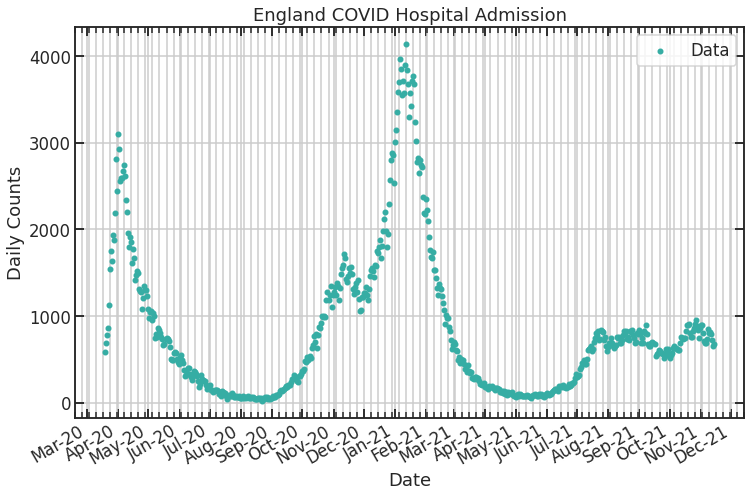

In [4]:
fig, ax = plt.subplots(figsize=(12,8),sharex= True, facecolor='white')

# Plot Hospital Admission against time
ax.scatter(df_Eng.index,df_Eng['Admissions'],label='Data',marker='.',c='C3')
ax.set_title('England COVID Hospital Admission')
fig.autofmt_xdate()

# Make it pretty
ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)
ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Counts')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
ax.set_title('England COVID Hospital Admission')
ax.legend()

# <a id="mobility"></a>2. [Import mobility metrics](#content)

In principle, covid cases, hospital admissions, and deaths are time-lagged outcomes of covariates or "predictor variables" such as the level of interactions in the population, mobility metrics, levels of restrictions etc.

A data set which is often used as a possible predictor is google mobility metrics https://www.google.com/covid19/mobility/.

In [5]:
#Import the data from Google.
#This is a large file!
df_google = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')
# df_google = pd.read_csv('Global_Mobility_Report.csv')

/home/ql1821/covid/lib64/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
#Select `United Kingdom` from the full data.
df_google = df_google[df_google['country_region']=='United Kingdom']
#Discard sub regions
#Note - we England vs UK
df_google = df_google[df_google['sub_region_1'].isnull()]

In [7]:
#Re-index by data
df_google.set_index(pd.to_datetime(df_google['date']),inplace=True)
df_google.sort_index(inplace=True)
df_google.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

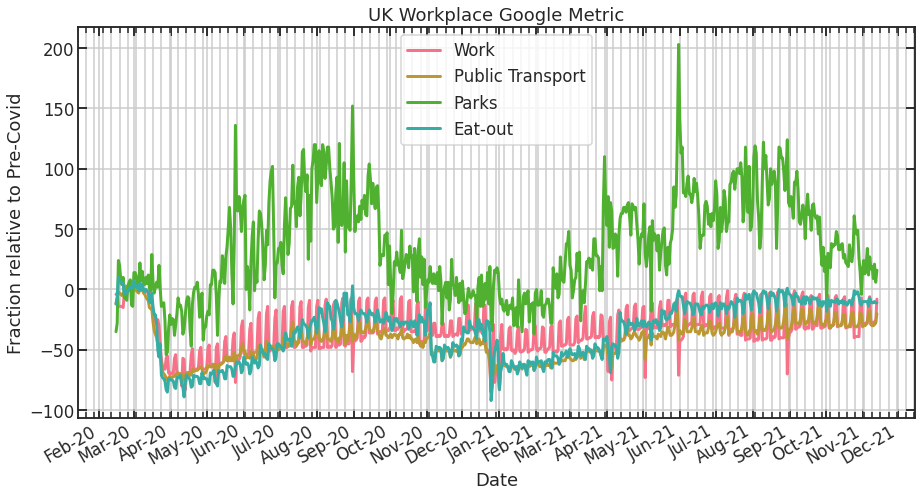

In [8]:
# plot some data
fig, ax = plt.subplots(figsize=(15,8),sharex= True, facecolor='white')

ax.plot(df_google.index,df_google['workplaces_percent_change_from_baseline'],label='Work')
ax.plot(df_google.index,df_google['transit_stations_percent_change_from_baseline'],label='Public Transport')
ax.plot(df_google.index,df_google['parks_percent_change_from_baseline'],label='Parks')
ax.plot(df_google.index,df_google['retail_and_recreation_percent_change_from_baseline'],label='Eat-out')


ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)
ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction relative to Pre-Covid')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax.set_title('UK Workplace Google Metric')
ax.legend()

_= fig.autofmt_xdate()

<div class="alert alert-success"> <p>
<b>Discussion: </b> 
As it is clearly shown in the graph above, there are periodic bumpings for mosy of the covariate in mobility metrics. The periodic feature will be captured in the process of modeling and cause over-fitting of the model. The model will also be unnecessarily complecated. Therefore, it is important to clean the data before modeling. 
    
</div>

# Analysis

## <a id="data"></a>3. [Data Cleaning](#content)

### <a id="shift"></a> [Data shifting](#content)

<div class="alert alert-info"> <p>
<b>Method</b>

Shift the data from Covid metrics due to its time-lagged outcome caused by the daily interations and activities along time. 14 days is chosen because the period for symptoms to show is from 5-14 days.

In [9]:
period_shift = -14
df_Eng0 = df_Eng.shift(periods=period_shift)

In [10]:
# Only import the wanted data which was quantified and rename them for simplication
df_google0 = df_google[["workplaces_percent_change_from_baseline",
                        "transit_stations_percent_change_from_baseline",
                        "parks_percent_change_from_baseline",
                        "retail_and_recreation_percent_change_from_baseline",
                        "grocery_and_pharmacy_percent_change_from_baseline",
                        "residential_percent_change_from_baseline"]].copy()

df_google0.columns = ['Work', 'Public Transport', 'Parks', 'Eat-out','Groceries and Pharmacy','Residential']

# df_google0['Residential'] = df_google0['Residential'].shift(periods=-12)

<div class="alert alert-info"> <p>

<b>Method</b>
    
<b>Obtain correlation coefficient<b>

The strength of correlation represent how much a covariant affect the trend of the pandemic. After trying different period of shifting, shifting with the largest absolute value of correlation coeffecient will be used for further research. 

The correlation coeffecient can also show which variable in the COVID metrics can be considered to have the strongest correlation with each covariate in mobility metrics. This way, whether the previous choice of `Hospital Admission` is appropriate will be verified numerically. 

**COVID metrics**: "Cases","Hospital", "Admissions", "Deaths". ;

**mobility metrics**: 'Work', 'Public Transport', 'Parks', 'Eat-out','Metro','Groceries and Pharmacy','Residential'.
</div>

In [11]:
# adding new columns from COVID metrics to mobility metrics and rename them for simplication
df_google0[["Covid Cases","Covid Hospital Cases",
            "Covid Hospital Admissions","Covid Deaths",
            ]] = df_Eng0[["Cases","Hospital", "Admissions", "Deaths"]]

df_google0_corr = df_google0.corr().copy()
df_google0_corr.iloc[0:-4,-4:] 

,Covid Cases,Covid Hospital Cases,Covid Hospital Admissions,Covid Deaths
Work,0.082313,-0.301987,-0.170200,-0.332920
Public Transport,0.154558,-0.528156,-0.315143,-0.516426
Parks,0.025799,-0.622754,-0.536145,-0.593299
Eat-out,0.345823,-0.449895,-0.238612,-0.475731
Groceries and Pharmacy,0.331787,-0.412530,-0.211913,-0.438586
Residential,-0.170248,0.443981,0.285846,0.472112


### <a id="rolling"></a>[Using rolling means to clean the data](#content)

<div class="alert alert-info"> <p>
    
<b>Method</b>
    
In this section, the data is cleaned with `DataFrame.rolling()` with a period of 7 due the periodic fluctuation of mobility data. The fluctuation of the activities can be largely affected by the alternation of weekdays and weekends. For example, the covariate `Public Transport` peaks on weekdays becaus of commutes.

Therefore, 7-day is the initial choice for the rolling period. 
</div>

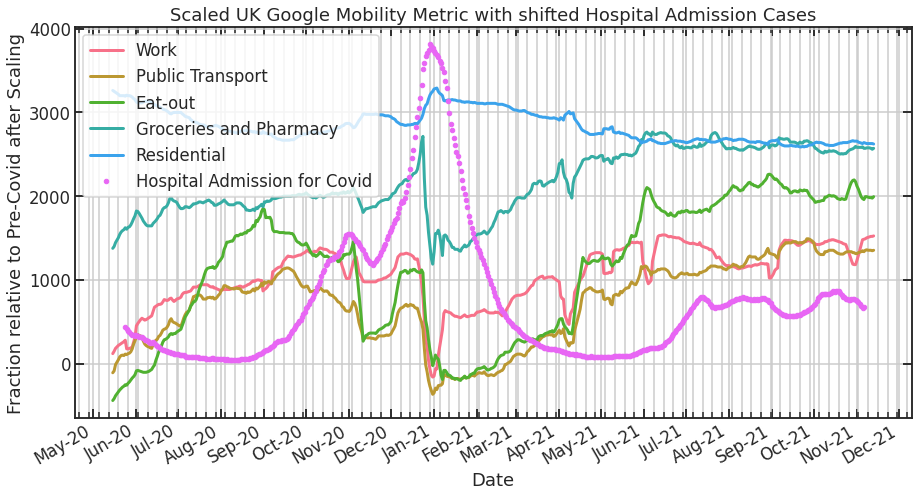

In [12]:
fig, ax = plt.subplots(figsize=(15,8),sharex= True, facecolor='white')

# Rolling means for covid variables
rolling_windows = df_Eng0["Admissions"].rolling(7, min_periods=1)
rolling_mean_Eng0 = rolling_windows.mean()

# Rolling means for predictors(mobility metrics)
for i in ("Work","Public Transport","Eat-out",'Groceries and Pharmacy','Residential'):
    # take 7-day rolling means to clean the data
    rolling_windows = df_google0[i].rolling(7, min_periods=1)
    rolling_mean = rolling_windows.mean()
    ax.plot(df_google.index[90:],40*(rolling_mean[90:]+60),label=i)

#plot the cleaned graph
ax.plot(df_Eng0.index[115:],rolling_mean_Eng0[115:],'.',label='Hospital Admission for Covid')
ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)
ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction relative to Pre-Covid after Scaling')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)

ax.set_title('Scaled UK Google Mobility Metric with shifted Hospital Admission Cases')
ax.legend()
_= fig.autofmt_xdate()

<div class="alert alert-success"> <p>
<b>Discussion</b> 
As it can be illustrated in the graph above, the periodic bumpings are mostly eliminated compare to the graph plotted in the last section. All the plots in mobility metrics are scaled so that the comparison of the COVID data and all selected covariated can be shown on the same graph. 
    
This graph can also be used to check the shifting period just by checking the alignment of the of COVID data and the mobility covariates. They should be aligned not only for the peaks but also for the general shap, which can also be presented by the correlation coefficient.
    
</div>

In [13]:
# create a data frame for cleaned data
data = {'Work':df_google0['Work'].rolling(7, min_periods=1).mean(),
        'Public Transport':df_google0['Public Transport'].rolling(7, min_periods=1).mean(), 
        'Parks':df_google0['Parks'].rolling(7, min_periods=1).mean(), 
        'Eat-out':df_google0['Eat-out'].rolling(7, min_periods=1).mean(),
        'Groceries and Pharmacy':df_google0['Groceries and Pharmacy'].rolling(7, min_periods=1).mean(),
        'Residential':df_google0['Residential'].rolling(7, min_periods=1).mean()}
df_rolling_mean_mobility = pd.DataFrame(data)

### <a id="s"></a>[Selecting](#content)

<div class="alert alert-info"> <p>
<b>Method</b> 

* Data is splitted into two sets: training set and testing set.The traning set is chosen as 80% of all data. The first month of data is not so useful because of the ralatively chaotic situation at the begining. Therefore, the 80% of the time will be from April 2020 to July 2021.
    
* The other important fact before start modeling is to eliminate all the unavailable data in the data set. Here `SimpleImputer` is chosen and the strategy to change the unavailable data is depending on different senarios.
    
</div>

In [14]:
print(' The size of training data will be {0:.0f}. \n Here, 80% of the total size was chosen as the training size.'.format(0.8*len(df_rolling_mean_mobility)))# print the lenth of data and choose 80% of it to be train data 

 The size of training data will be 510. 
 Here, 80% of the total size was chosen as the training size.


# <a id="lr"></a>4. [Linear regression](#content)

<div class="alert alert-info"> <p>

<b>Introduction</b>
    
The idea of using linear regression in this case is to parameterize the trend of Covid-19 with known relative factors. The relation between the model and the covariates can be expressed as followed:

$$
\mathbf{Y_{Covid}} = \mathbf{M}\mathbf{\mathit{X}_{mobility}}+\mathbf{c}
$$

Where $Y_{Covid} = (Y_1,Y_2,Y_3,...,Y_n)$ is a set of variables from Covid metrix. Here we only need one set of data to analyse, `Hospital Admission` was chosen in this case. The $\mathbf{\mathit{X}_{mobility}} = (X_1,X_2,X_3,...,X_n)$ is a set of variables from mobility metrics. 

The $n\times m$ matrix $\mathbf M$ and the vector $\mathbf c$ which minimize the error function are the quantities we are looking for in the process of linear regression.

In the first trial, the variables selected for $\mathbf{Y_{Covid}}$ will be: 'Cases','Hospital', 'Admissions', 'Deaths'; the variables selected for $\mathbf{\mathit{X}_{mobility}}$ will be: 'Work', 'Public Transport', 'Parks', 'Eat-out'

After cleaning the data, the regression analysis can now be set up with `sklearn` for linear regression and statsmodel for better presentation of multivariable linear regression coefficients and other related quantities.
    
    
<b>Plotting and Calibration</b>

<b>Plotting:</b>
After obtaining the quantities for the model, a plot of the predictive model and the observed data should be plotted on the same graph to show the quanlity of the prediction. The equation used to plot the model is also shown in the graph below.

<b>Calibration:</b>
The calibration quantities used in this model is the error of model and its accuracy score. A model with smaller error and higher percentage of the accuracy score is considered as a better model without considering the overfitting of the model.
    
</div>

## <a id="initial"></a> [Initial Model with All Covariates in Mobility metrics](#content)

In [15]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error 


# transform Nan values into constant for regression using SimpleImputer
imp = SimpleImputer(strategy="constant")
X_train = imp.fit_transform(df_rolling_mean_mobility[60:510])
X_test = imp.fit_transform(df_rolling_mean_mobility[510:])
Y_train = imp.fit_transform(np.array(df_google0['Covid Hospital Admissions'][60:510]).reshape(-1,1))
Y_test = imp.fit_transform(np.array(df_google0['Covid Hospital Admissions'][510:]).reshape(-1,1))
# X =df_rolling_mean_mobility.dropna()
# Y =np.array(df_google0['Covid Hospital Admissions'].dropna()).reshape(-1,1)

# with sklearn
lin_reg = LinearRegression()# define LinearRegression
lin_reg.fit(X_train,Y_train)# fit linear regression with given data sets

# with statsmodels
#X_train = sm.add_constant(X_train) # adding a constant
model = sm.OLS(Y_train, X_train).fit()
predictions = model.predict(X_train) # predict the model with known data

print_model = model.summary()# prepare to print the summary table if needed

### <a id="pi"></a> [Plotting](#content)

Intercept: 
 [-59.22695015]
Coefficients: 
 [[ 61.69786875 -63.81744641 -11.42117938 112.35735059  -8.64805601
  382.66652089]]
The accuracy score of model is: 0.7635304493272937


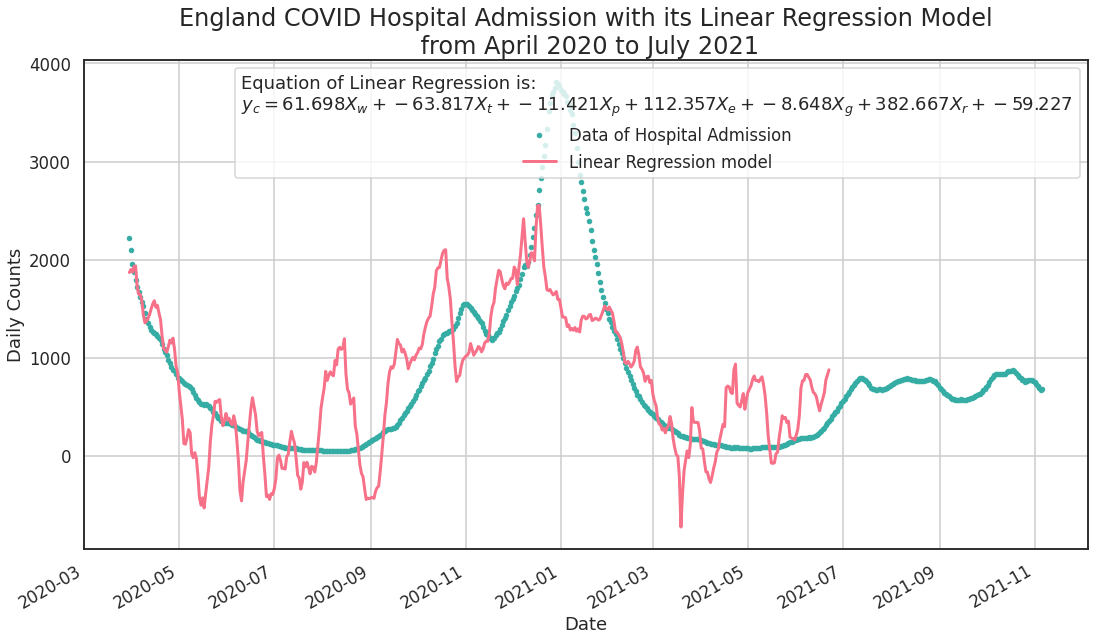

In [16]:
fig, ax = plt.subplots(figsize=(18,10),sharex= True, facecolor='white')# set the graph to a proper size

# plot both provided data and the prediction with appropriate labels
plt.plot(df_Eng.index[60:],rolling_mean_Eng0[60:],'.',label='Data of Hospital Admission',c='C3')
plt.plot(df_Eng0.index[60:510],predictions[:],label = 'Linear Regression model')
plt.xlabel('Date')
plt.ylabel('Daily Counts')
plt.title('England COVID Hospital Admission with its Linear Regression Model\n from April 2020 to July 2021',fontsize = 24)
plt.grid(which='both')
_= fig.autofmt_xdate()
# use a loop to put the equation on the graph
fit_info = [f"Equation of Linear Regression is:",]
p = lin_reg.coef_.reshape(-1,1)
for k, v, e,h,g,gr,r in zip(lin_reg.intercept_,p[0],p[1],p[2],p[3],p[4],p[5]):
    fit_info.append(f"$y_c = {v:.3f}X_w+ {e:.3f}X_t + {h:.3f}X_p + {g:.3f}X_e + {gr:.3f}X_g + {r:.3f}X_r + {k:.3f}$")
plt.legend(title="\n".join(fit_info),loc='best')

# print out important quantities
print('Intercept: \n', lin_reg.intercept_)
print('Coefficients: \n', lin_reg.coef_)
print("The accuracy score of model is:", model.rsquared)

<div class="alert alert-success"> <p>
<b>Discussion</b> 
    
* The multivariables linear regression prediction has a similar shape compares to the real data of `Hospital Admission`, i.e. they show the feature of having one global peak in the middle and two valleys on the sides.
    
* However, the model is highly deformed compared to the real data as in it shows a feature of small wiggles at both the peak and valleys, it might be a outcome of overfitting or mis-implementation of the data (wrong shifting, wrong rolling periods, wrong chosen covariates etc.). This assumption is also supported by the fatc that the model has a significant error of 571 and the accuracy score of the model is only 76%.
    
* To improve the prediction, more related varibles can be introduced into the model. In this case, daily reported cases of full vaccination is chosen to adjust the model.
</div>

### <a id="backi"></a> [Back Test](#content)

the error of this model is: 454.9267594827206
The accuracy score of model is: 0.7635304493272937


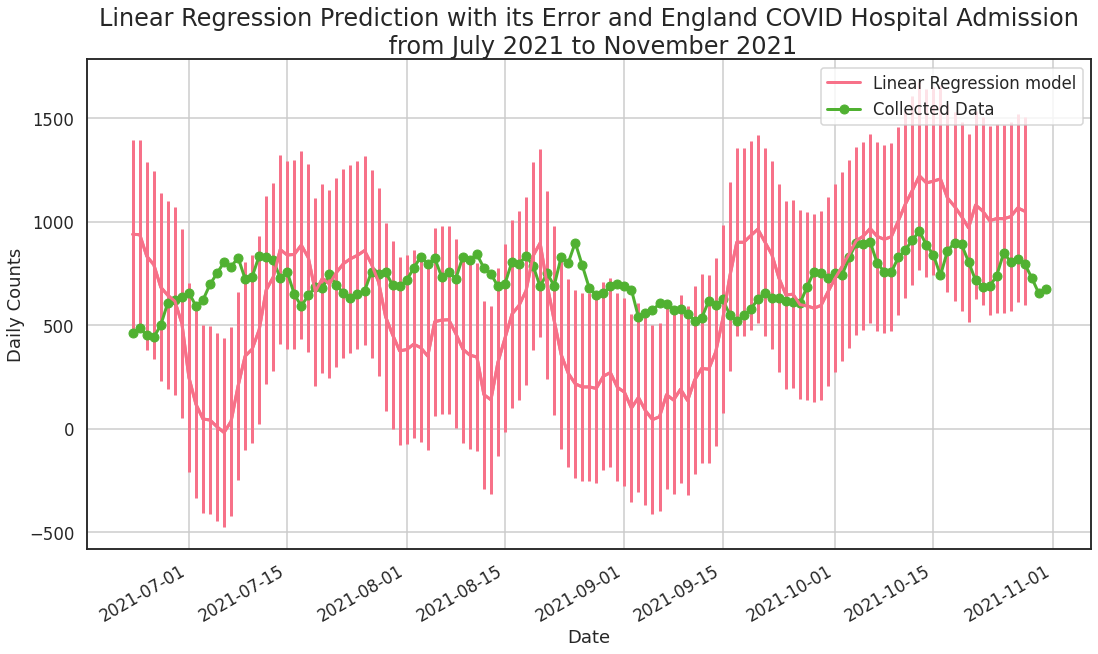

In [17]:
fig, ax = plt.subplots(figsize=(18,10),sharex= True, facecolor='white')# set graph size

df_new = pd.date_range('07/08/2020', periods=-period_shift, freq="D")# set new range for dates

prediction = model.predict(X_test)# make new prediction for the last 7 days

# plot the prediction for 14 days(7 known 7 unknown)
plt.plot(df_Eng0.index[510:-19],prediction,label = 'Linear Regression model')
plt.plot(df_Eng0.index[510:],df_Eng0['Admissions'][510:],'o-',label = 'Collected Data',c='C2')
plt.xlabel('Date')
plt.ylabel('Daily Counts')
plt.title('Linear Regression Prediction with its Error and England COVID Hospital Admission\n from July 2021 to November 2021',fontsize = 24)
plt.grid(which='both')
_= fig.autofmt_xdate()
plt.legend()

# print the error of the model to calibrate the model
error = np.sqrt(mean_squared_error(Y_test,prediction))
plt.errorbar(df_Eng0.index[510:-19],prediction,error,c='C6')
print('the error of this model is:',error)
print("The accuracy score of model is:", model.rsquared)

<div class="alert alert-success"> <p>
<b>Discussion</b> 
    
* The back test shows that the model does not completely agree with the real-time data. The model fits the data slightly better when takes its error into account. 
    
* Therefore, the model should be improved as previously stated. In this case, the reported cases of full vaccination per day might be helful to choose as another factor to present the trend of the pandemic.
    
</div>

In [18]:
df_Eng_new = df_Eng['Full Vaccination'][334:len(X_train)]# select available data(vaccination programme started in one year)

data1 = {'Work':df_google0['Work'].rolling(7, min_periods=1).mean(),
        'Public Transport':df_google0['Public Transport'].rolling(7, min_periods=1).mean(),
        'Parks':df_google0['Parks'].rolling(7, min_periods=1).mean(), 
        'Eat-out':df_google0['Eat-out'].rolling(7, min_periods=1).mean(),
        'Groceries and Pharmacy':df_google0['Groceries and Pharmacy'].rolling(7, min_periods=1).mean(),
        'Residential':df_google0['Residential'].rolling(7, min_periods=1).mean(),
        'Full Vaccination':df_Eng_new.rolling(7, min_periods=1).mean()}
df_rolling_mean_mobility1 = pd.DataFrame(data1)# new cleaned dataframe with vaccine 

## <a id="v"></a>[Model after adding vaccination as a covariate](#content)

In [19]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.impute import SimpleImputer

# transform Nan values into constant for regression using SimpleImputer
imp = SimpleImputer(strategy="median")
X_0_train = imp.fit_transform(df_rolling_mean_mobility1[334:510])
X_0_test= imp.fit_transform(df_rolling_mean_mobility1[510:])
Y_0_train = imp.fit_transform(np.array(df_google0['Covid Hospital Admissions'][334:510]).reshape(-1,1))
Y_0_test = imp.fit_transform(np.array(df_google0['Covid Hospital Admissions'][510:]).reshape(-1,1))
# with sklearn
lin_reg.fit(X_0_train,Y_0_train)


# with statsmodels
#X_0 = sm.add_constant(X_0) # adding a constant
model_v = sm.OLS(Y_0_train, X_0_train).fit()
predictions_v = model_v.predict(X_0_train) 

### <a id="pv"></a>[Plotting](#content)

Intercept: 
 [1198.49495383]
Coefficients: 
 [[  38.4074188   -36.90147355    8.18172984   37.96746878 -134.20618179
   -52.32641216]]
the accuracy score of model is: 0.9077082859854652


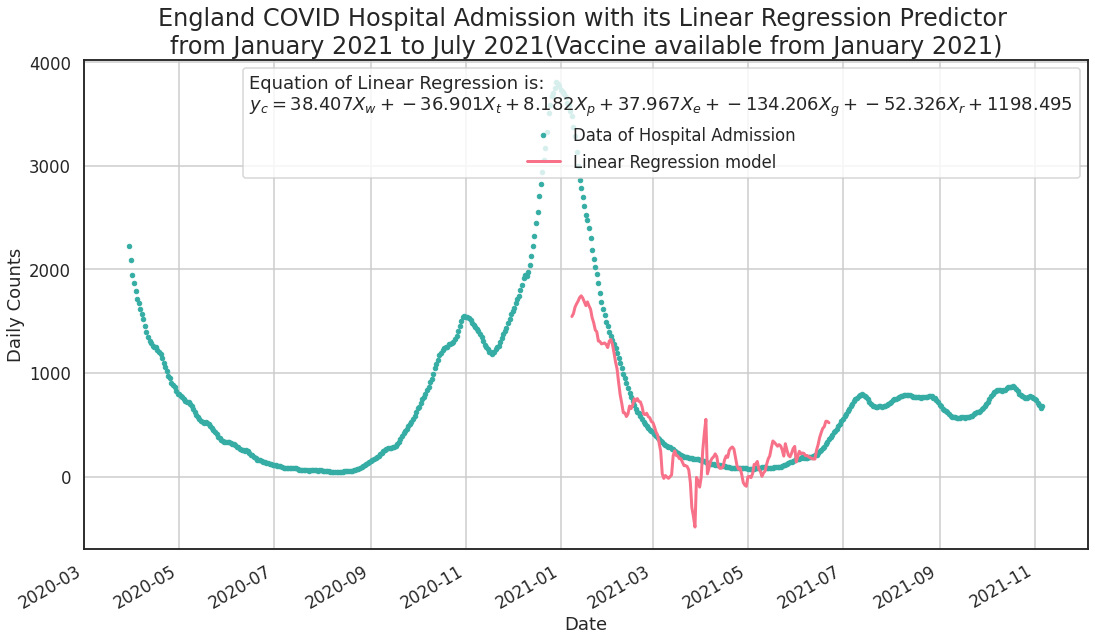

In [20]:
fig, ax = plt.subplots(figsize=(18,10),sharex= True, facecolor='white')

# plot both provided data and the prediction with appropriate labels
plt.plot(df_Eng0.index[60:],rolling_mean_Eng0[60:],'.',label='Data of Hospital Admission',c='C3')
plt.plot(df_Eng0.index[344:510],predictions_v[:-10],label = 'Linear Regression model')
plt.xlabel('Date')
plt.ylabel('Daily Counts')
plt.title('England COVID Hospital Admission with its Linear Regression Predictor \nfrom January 2021 to July 2021(Vaccine available from January 2021)',fontsize = 24)
plt.grid(which='both')
_= fig.autofmt_xdate()

# print out important quantities
print('Intercept: \n', lin_reg.intercept_)
print('Coefficients: \n', lin_reg.coef_)
print("the accuracy score of model is:", model_v.rsquared)

# use a loop to put the equation on the graph
fit_info = [f"Equation of Linear Regression is:",]
p_v = lin_reg.coef_.reshape(-1,1)
for k_v, v_v, e_v,h_v,g_v,gr_v,r_v in zip(lin_reg.intercept_,p_v[0],p_v[1],p_v[2],p_v[3],p_v[4],p_v[5]):
    fit_info.append(f"$y_c = {v_v:.3f}X_w+ {e_v:.3f}X_t + {h_v:.3f}X_p + {g_v:.3f}X_e + {gr_v:.3f}X_g + {r_v:.3f}X_r + {k_v:.3f}$")
plt.legend(title="\n".join(fit_info),loc='best')

<div class="alert alert-success"> <p>

<b>Discussion</b>

* This partial modeling shows a relatively better fitting to the real data. However, the fluctuation observed in the previous model is still noticeable.
    
* The error and accuracy score also draw the same conclusion. The accuracy scare reached 91% which is better than the previous one of around 76%. It means choosing vaccination data as calibration was a good decision.
    
* The error is still significant and further analysis will be carried out in section 6. A prediction with assosiated errors from this improved model can also be used for back testing.

</div>

### <a id="backv"></a> [Back test](#content)

the error of this model is: 323.6845145416917
The accuracy score of model is: 0.9077082859854652


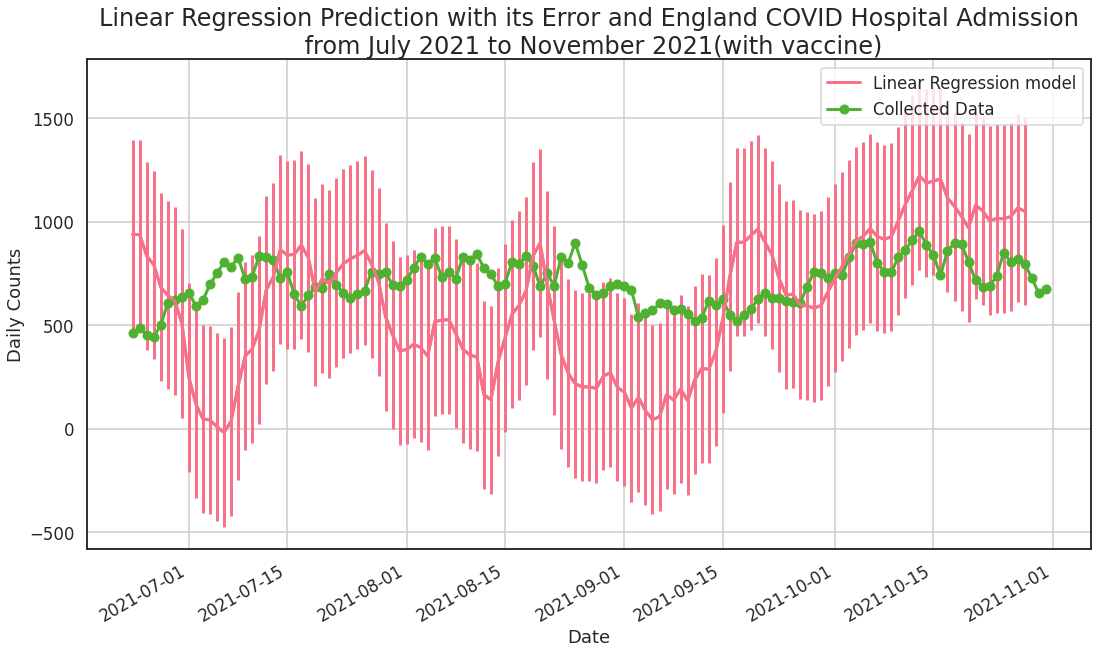

In [21]:
fig, ax = plt.subplots(figsize=(18,10),sharex= True, facecolor='white')# set graph size

df_new = pd.date_range('07/08/2020', periods=-period_shift, freq="D")# set new range for dates

prediction_0 = model.predict(X_0_test)# make new prediction for the last 7 days

# plot the prediction for 14 days(7 known 7 unknown)
plt.plot(df_Eng0.index[510:-19],prediction_0,label = 'Linear Regression model')
plt.plot(df_Eng0.index[510:],df_Eng0['Admissions'][510:],'o-',label = 'Collected Data',c='C2')
plt.xlabel('Date')
plt.ylabel('Daily Counts')
plt.title('Linear Regression Prediction with its Error and England COVID Hospital Admission\n from July 2021 to November 2021(with vaccine)',fontsize = 24)
plt.grid(which='both')
_= fig.autofmt_xdate()
plt.legend()

# print the error of the model to calibrate the model
error_0 = np.sqrt(mean_squared_error(Y_0_test,prediction_0))
plt.errorbar(df_Eng0.index[510:-19],prediction,error,c='C6')

print('the error of this model is:',error_0)
print("The accuracy score of model is:", model_v.rsquared)

<div class="alert alert-success"> <p>

<b>Discussion</b>

* As it is shown in the graph, the error is still large when the number of cases is around 800. However, it improved slightly compared with the previous model (from 454.9 to 323.7). 

* More adjustment is needed to make improvement.
</div>

### Check Linearality of each covariate

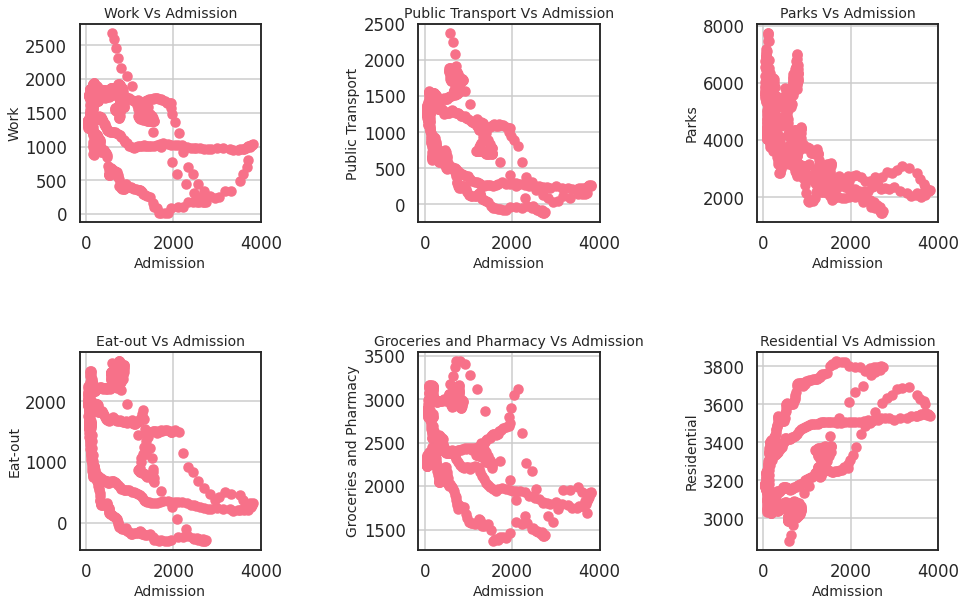

In [22]:
# print(len(rolling_mean_Eng0),len(df_rolling_mean_mobility['Work']))
# print(rolling_mean_Eng0[35:643])
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')



for i in range(1,7):
    plt.subplot(2,3,i)
    mobi = df_rolling_mean_mobility.columns[i-1]
    k = 35-(643-len(df_rolling_mean_mobility[mobi]))
    plt.scatter(rolling_mean_Eng0[35:643], 40*(df_rolling_mean_mobility[mobi][k:]+70))
    plt.title('{0} Vs Admission'.format(mobi), fontsize=14)
    plt.xlabel('Admission', fontsize=14)
    plt.ylabel('{0}'.format(mobi), fontsize=14)
    plt.grid(True)
    
fig.tight_layout(pad=2.0)

<div class="alert alert-success"> <p>

<b>Discussion</b>
    
* All of the covariate does not show a strong linearity relation with the quantity we want to predict. However, there are certain periods of time showed a linear feature with respect to `Hospital Admission`. These periods are observed in mobility metrics: `Work`,`Public Transport`,`Eat-out`,`Grouceries`.
    
* Therefore, the model might only be reliable for a certain range of time for each covariate.
    
</div>

## <a id="n"></a>[Non-Linear regression model](#content)

<div class="alert alert-info"> <p>
<b>Method</b>    
    
As it is shown in the previous graphs, Linear regression might not be the most appropriate model to make prediction. A better way for modeling for this case might be using the `PolynomialFeatures`. 
</div>

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error 


poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X_train)

poly_features_n = PolynomialFeatures(degree=2, include_bias=False)
X_poly_test = poly_features_n.fit_transform(X_test)
# with sklearn
lin_reg_n = LinearRegression()# define LinearRegression
lin_reg_n.fit(X_poly,Y_train)# fit linear regression with given data sets
 
# with statsmodels
#X_train = sm.add_constant(X_train) # adding a constant
model_n = sm.OLS(Y_train, X_poly).fit()
predictions_n = model_n.predict(X_poly) # predict the model with known data


### <a id="pn"></a>[Plotting](#content)

Intercept: 
 [-6306.09295174]
Coefficients: 
 [[ 5.43852333e+02 -7.91190504e+02  7.23532685e+01 -2.13594064e+02
   1.74050727e+02 -1.06749762e+03  2.00378217e+01 -9.34793395e+00
  -8.13720686e-01  9.52057954e+00 -6.37571954e+00  7.48634618e+01
  -1.34210230e+01  1.92934634e+00 -2.18419911e+01  1.67260756e+01
  -1.29837116e+02 -1.10353196e-01 -1.70338023e+00 -7.04760472e-01
  -6.51428504e+00  6.65222381e+00  6.69052837e-01  1.52216318e+01
   3.65340288e+00  3.76002908e+01 -2.97918066e+01]]
The accuracy score of model is: 0.9356847593335503


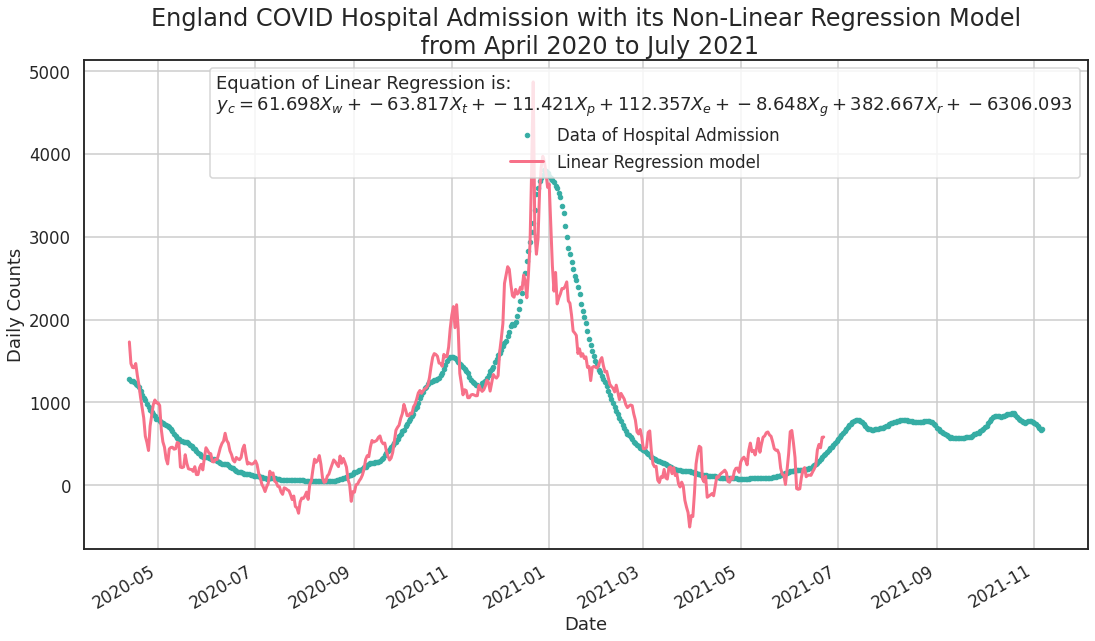

In [24]:
fig, ax = plt.subplots(figsize=(18,10),sharex= True, facecolor='white')# set the graph to a proper size

# plot both provided data and the prediction with appropriate labels
plt.plot(df_Eng.index[74:],rolling_mean_Eng0[74:],'.',label='Data of Hospital Admission',c='C3')
plt.plot(df_Eng0.index[74:510],predictions_n[:-14],label = 'Linear Regression model')
plt.xlabel('Date')
plt.ylabel('Daily Counts')
plt.title('England COVID Hospital Admission with its Non-Linear Regression Model\n from April 2020 to July 2021',fontsize = 24)
plt.grid(which='both')
_= fig.autofmt_xdate()
# use a loop to put the equation on the graph
fit_info_n = [f"Equation of Linear Regression is:",]
p_n = lin_reg_n.coef_.reshape(-1,1)
for k, v, e,h,g,gr,r in zip(lin_reg_n.intercept_,p[0],p[1],p[2],p[3],p[4],p[5]):
    fit_info_n.append(f"$y_c = {v:.3f}X_w+ {e:.3f}X_t + {h:.3f}X_p + {g:.3f}X_e + {gr:.3f}X_g + {r:.3f}X_r + {k:.3f}$")
plt.legend(title="\n".join(fit_info_n),loc='best')

# print out important quantities
print('Intercept: \n', lin_reg_n.intercept_)
print('Coefficients: \n', lin_reg_n.coef_)

print("The accuracy score of model is:", model_n.rsquared)

<div class="alert alert-success"> <p>

<b>Discussion</b>

* This obviously shows a betterfit with the training data, especially the peak. 
    
* The accuracy score is 93.5%, which is much higher than the initial model.
    
* However, the fluctuations still exist and the model presents a sign of overfitting. This can be verified by running a back test again.
</div>

### <a id="backn"></a> [Back test](#content)

the error of this model is: 615.4569250838362
The accuracy score of model is: 0.9356847593335503


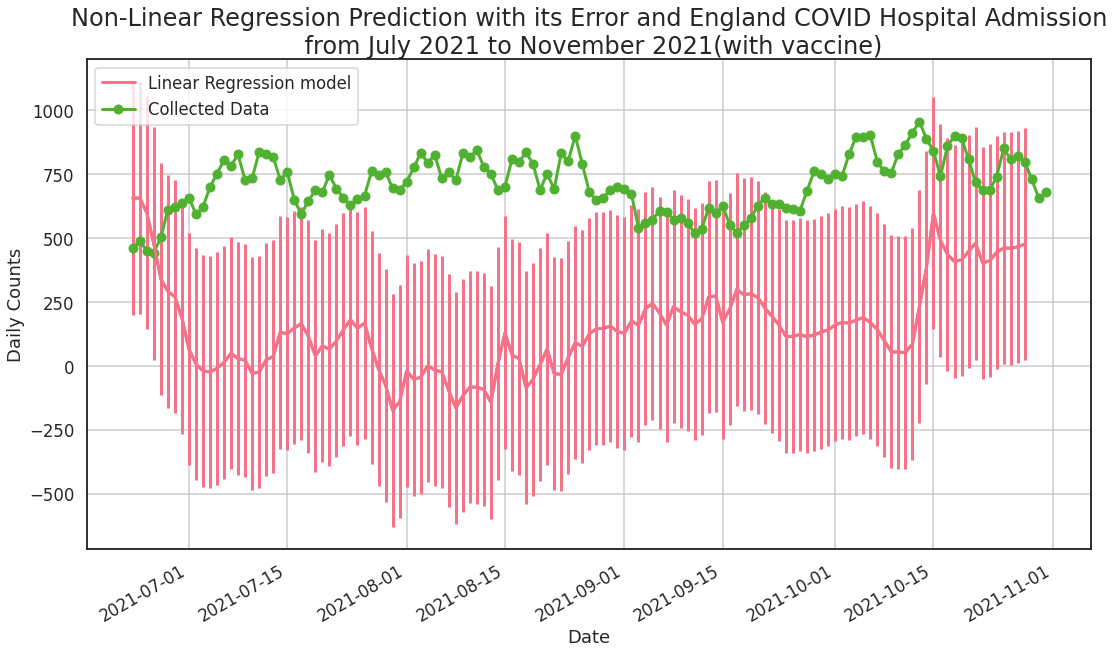

In [25]:
fig, ax = plt.subplots(figsize=(18,10),sharex= True, facecolor='white')# set graph size

df_new = pd.date_range('07/08/2020', periods=-period_shift, freq="D")# set new range for dates

prediction_n = model_n.predict(X_poly_test)# make new prediction for the last 7 days

# plot the prediction for 14 days(7 known 7 unknown)
plt.plot(df_Eng0.index[510:-19],prediction_n,label = 'Linear Regression model')
plt.plot(df_Eng0.index[510:],df_Eng0['Admissions'][510:],'o-',label = 'Collected Data',c='C2')
plt.xlabel('Date')
plt.ylabel('Daily Counts')
plt.title('Non-Linear Regression Prediction with its Error and England COVID Hospital Admission\n from July 2021 to November 2021(with vaccine)',fontsize = 24)
plt.grid(which='both')
_= fig.autofmt_xdate()
plt.legend()

# print the error of the model to calibrate the model
error_n = np.sqrt(mean_squared_error(Y_test,prediction_n))
plt.errorbar(df_Eng0.index[510:-19],prediction_n,error,c='C6')

print('the error of this model is:',error_n)
print("The accuracy score of model is:", model_n.rsquared)

<div class="alert alert-success"> <p>

<b>Discussion</b>

Although the accuracy score is considerably high compareto the initial model, the error of this model is much higher than the previous cases. This might be a proof of the previous assumption of overfitting, the model is too well trained with the unwanted features it captured from the covariates. Even with such a significant error, the real still does not fit in this model.
    
</div>    

## Plot Learning Curve

One way to verify an overfitting model is to plot the Learning Curve of this model. If the training error is much smaller than the validation error, it will be a hallmark of an over fitting model.

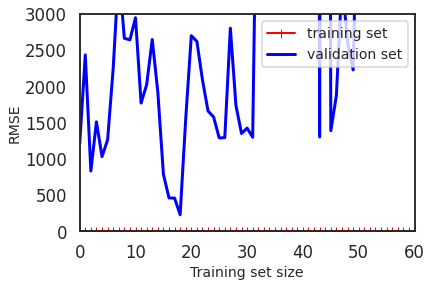

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


def plot_learning_curves(model, X, y):
    X_train = imp.fit_transform(X[60:132])
    X_val = imp.fit_transform(X[132:150])
    y_train = imp.fit_transform(np.array(Y[60:132]).reshape(-1,1))
    y_val = imp.fit_transform(np.array(Y[132:150]).reshape(-1,1))
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="training set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation set")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)      
    
    
X = imp.fit_transform(df_rolling_mean_mobility)
Y = imp.fit_transform(np.array(df_google0['Covid Hospital Admissions']).reshape(-1,1))

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=15, include_bias=False)),
        ("lin_reg", LinearRegression()),])

plot_learning_curves(polynomial_regression, X, Y)
          # not shown
plt.axis([0, 60, 0, 3000])   
plt.show()

<div class="alert alert-success"> <p>

<b>Discussion</b>
    
It is clearly shown that the validation error is much higher than the training error depiste the growth of training set. This verified the asscomption of overfitting in the last section.

</div>

## <a id="pred"></a> [Fortnight Prediction](#content)

Overall, the best model in this project is the Vaccine embedded one. Therefore, we can use this model to predict the trend in two weeks two because of the time lagged feature of pandemic when it is compared to the mobility metrics.

the error of this model is: 281.7566447030608
The number of Hospital Admission cases is predicted to be 347 with en erro of 282


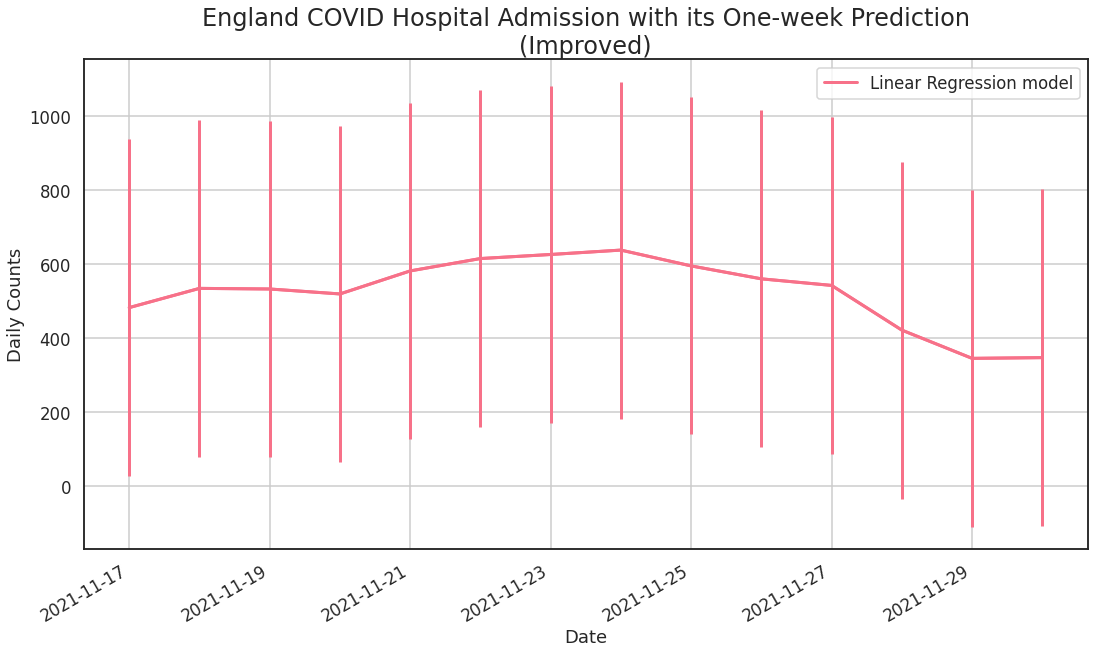

In [27]:
from datetime import datetime

# import current time using datetime
now = datetime.now()
current_time = now.strftime("%Y-%m-%d")


fig, ax = plt.subplots(figsize=(18,10),sharex= True, facecolor='white')

df_new = pd.date_range(current_time, periods=-period_shift, freq="D")

prediction_v = model_v.predict(X_0_train[period_shift:])

plt.plot(df_new,prediction_v,label = 'Linear Regression model')
plt.xlabel('Date')
plt.ylabel('Daily Counts')
plt.title('England COVID Hospital Admission with its One-week Prediction\n(Improved)',fontsize = 24)
plt.grid(which='both')
_= fig.autofmt_xdate()
plt.legend()

error_v = np.sqrt(mean_squared_error(df_Eng["Admissions"][(-3+period_shift):-3],prediction_v))
plt.errorbar(df_new,prediction_v,error,c='C6')
print('the error of this model is:',error_v)
print('The number of Hospital Admission cases is predicted to be {0:.0f} with en erro of {1:.0f}'.format(prediction_v[-1],error_v))

<div class="alert alert-success"> <p>

<b>Discussion</b>
    
The error of this prediction is about 82% of its value, which is way too large than what is expected. 

</div>

#  <a id="dc"></a>[Discussion and Conclusion](#content)

In this mini-project, Linear Regression was used as a method to predict future with collected data. However, it is not alwasy powerful in all scenarios. Two ways of improving the prediction were discussed in details in this case:

* Adding another factor that may impact on the quantity we want to predict.
* Using another method such as Non-Linear Regression.

The first one is more empirically based, it has a higher demand for the experience on the topic to help locating the best added covariates. 

The second method can provide a better model for training but it is also easier to be over-trained and bring larger error on the predictions.

The model still did not work decently after these adjustments so there might be more factors that affect the trend significantly. Here are some of the assumptions:

### Long-term analysis

"As time passes and we move further away from the baseline period, populations might vary due to relocation or new regional and remote working options. Google’s understanding of categorized places might also change. For example, the same value today and in April 2020 might not indicate the same behavior or adherence—it might be that Google has updated information about shops and restaurants in the region or that fewer people live there now. These differences could shift the values up or down over long time periods, so we recommend using some caution when analyzing data from longer time intervals (6+ months)."

Analysis in this project are mostly using the data over 6+ month. Therefore, this might be one of the reason to re-evaluate the reliability of the data in the mobility metrics.

### Impact from other dimension

Apart from the interactions among population, there are also other factors that will affect the trend of pandemic significantly. For example, a series of analysis can be done with the comparison between different categaries with respect to mortality rate. This can be used to anayze how much some factor will affect the spread of COVID.

Futher research can be done with the following structure:

* Find the data of cumulative deaths classified in different ways. 
* Import data of cumulative deaths and devide it by hospital admissions to obtain mortality rate. Set the y_axis as mortality rate.
* Plot bar charts in different ways of categarization, here are some thoughts:
    * Set x-axis as age groups
    * Set x-axis as regions
    * Set x-axis as underline health conditions
    * Analyze change in mortality rate while cases of full vaccination increase
* Time series analysis for R. (R is the number of people that one infected person will pass on a virus to, on average.) 